In [3]:
import csv
import json
import requests
import pprint

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.cluster import KMeans

%matplotlib inline

pd.set_option('display.max_columns', None)
data = pd.read_csv('data/Second_half_2019_over0.csv', header=[0,1], index_col=0)
# data1 = pd.read_csv('data/sortby_MAC_Time_2019.csv', header=[0,1], index_col=0)

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# 데이터의 주기성 
- 매달의 첫주부터 넷재주까지의 주기
- 6개월간의 요일마다 연결되는 세션의 주기성
- 6개월간 시간마다(평일, 주말) 연결되는 세션의 주기성

## 시간마다 연결되는 세션의 주기성

- 7, 8, 9, 10, 11, 12월 평일 매 시간마다 평균
- 7, 8, 9, 10, 11, 12월 주말 매 시간마다 평균
으로 그래프 그리기

In [4]:
data.head(3)

l1               AP                     \
0        l2       IP Address        MAC Address   
2   3451965    172.20.146.92  08:17:35:c7:5c:50   
10   459471  164.125.168.248  10:8c:cf:10:8d:a0   
11    21181  164.125.175.247  84:3d:c6:ea:62:40   

                                                          Client  \
0                      Map Location           Name Endpoint Type   
2     PUSAN-OUTDOOR > PUSAN-OUTDOOR  11S-508-OUT-2    Android-LG   
10    PUSAN-OUTDOOR > PUSAN-OUTDOOR    SAP-168.248    Android-LG   
11  Pusan > GunSul (401) > GunSul2F   16AP-401-2-1    Android-LG   

                                          Session Duration                \
0        IP Address MAC Address      SSID             days hours minutes   
2    164.125.250.67           0  PNU-WiFi                0     0      35   
10  164.125.250.193           0  PNU-WiFi                0     0       5   
11  164.125.250.193           0  PNU-WiFi                0     1      21   

                              Utilization                            \
0  seconds Avg. Session Throughput (Kbps) Bytes Received Bytes Sent   
2        6                            6.8         159257      95660   
10       2                            4.2         344101     132199   
11       9                          115.2       51125667    5383309   

                                                                               \
0  Data Retries Packets Received Packets Sent RSSI (dBm) RTS Retries SNR (dB)   
2           278              327          383        -87           0        8   
10        15411              693          787        -52           0       39   
11        13780            44552        37590        -65           0       27   

    Disassociation Time     Association Time  
0   Unnamed: 23_level_1  Unnamed: 24_level_1  
2   2019-05-19 01:24:52  2019-05-19 00:49:46  
10  2019-05-20 08:57:48  2019-05-20 08:52:46  
11  2019-05-20 10:18:58  2019-05-20 08:57:49

In [5]:
myday = pd.to_datetime(data[('DisassociationTime', 'Unnamed: 23_level_1')])
data[('Day Of Week', 'day')] = myday.dt.day_name()

## 날짜마다 시간별로 세션개수 저장

In [6]:

def session_num_in_one_day_of_week(day):
    the_day = data[data[('Day Of Week', 'day')] == day]
    
    oneday_of_week = {}
    for time in range(0,24):

        pre_s = ""
        pre_e = ""

        if time < 10:
            pre_s = "0"+str(time)
        else:
            pre_s = str(time)

        if time +1 < 10:
            pre_e = "0"+str(time+1)
        else:
            pre_e = str(time+1)

        pre_s+=":00:00"
        pre_e+=":00:00"

        for i, a, b in zip(data.index, the_day[('Association Time', 'Unnamed: 24_level_1')].values, the_day[('Disassociation Time', 'Unnamed: 23_level_1')].values):
            strat = a.split(" ")[1]
            end = b.split(" ")[1]
            con1 = strat >= pre_s and end <= pre_e
            con2 = strat <= pre_s and end >= pre_e
            con3 = strat <= pre_s and end <= pre_e and end >= pre_s
            con4 = strat >= pre_s and end >= pre_e and strat <= pre_e
            if con1 or con2 or con3 or con4:
                change_to_date = pd.to_datetime(a)
                changed_date = change_to_date.date()
                if changed_date in oneday_of_week:
                    oneday_of_week[changed_date].append(time)
                else:
                    oneday_of_week[changed_date] = [time]
    return oneday_of_week


In [7]:
mon = session_num_in_one_day_of_week('Monday')
tue = session_num_in_one_day_of_week('Tuesday')
wed = session_num_in_one_day_of_week('Wednesday')
thu = session_num_in_one_day_of_week('Thursday')
fri = session_num_in_one_day_of_week('Friday')
sat = session_num_in_one_day_of_week('Saturday')
sun = session_num_in_one_day_of_week('Sunday')

In [8]:
# 평일 주기, 주말 주기 다름

In [9]:
def change_to_number(dayday):
    day_dt = dayday
    Ret = {}
    for d_t in day_dt:
        dic = {}

        for hour in day_dt[d_t]:
            if hour in dic:
                dic[hour] +=1
            else:
                dic[hour] = 1

            if d_t in Ret:
                Ret[d_t].update(dic)
            else:
                Ret[d_t] = dic
    return Ret

In [10]:
Mon = change_to_number(mon)
Tue = change_to_number(tue)
Wed = change_to_number(wed)
Thu = change_to_number(thu)
Fri = change_to_number(fri)
Sat = change_to_number(sat)
Sun = change_to_number(sun)

# 요일별로 시간마다 모든 날짜에서 세션 평균 구하기

In [11]:

def day_avg(dayday):
    avg_Mon = {}
    day_dt = dayday
    
    for hour in range(0,24):
        m_avg = 0
        m_sum = 0
        cnt = 0
        for m in day_dt:
            cnt+=1
            if hour in day_dt[m]:
                m_sum +=day_dt[m][hour]
            else:
                m_sum +=0
        m_avg = m_sum/cnt

        avg_Mon[hour] = m_avg
        
    return avg_Mon
    

In [12]:
mon_avg = day_avg(Mon)
tue_avg = day_avg(Tue)
wed_avg = day_avg(Wed)
thu_avg = day_avg(Thu)
fri_avg = day_avg(Fri)
sat_avg = day_avg(Sat)
sun_avg = day_avg(Sun)

In [13]:
mon_df = pd.DataFrame(pd.Series(mon_avg), columns=['avg'])
tue_df = pd.DataFrame(pd.Series(tue_avg), columns=['avg'])
wed_df = pd.DataFrame(pd.Series(wed_avg), columns=['avg'])
thu_df = pd.DataFrame(pd.Series(thu_avg), columns=['avg'])
fri_df = pd.DataFrame(pd.Series(fri_avg), columns=['avg'])
sat_df = pd.DataFrame(pd.Series(sat_avg), columns=['avg'])
sun_df = pd.DataFrame(pd.Series(sun_avg), columns=['avg'])

In [14]:
totalday = pd.concat([mon_df,tue_df, wed_df, thu_df, fri_df, sat_df, sun_df])

In [15]:
totalday = totalday.reset_index()

In [16]:
totalday = totalday.drop(['index'], axis='columns')

In [17]:
totalday.head(3)

,avg
0,130.117647
1,125.509804
2,116.627451


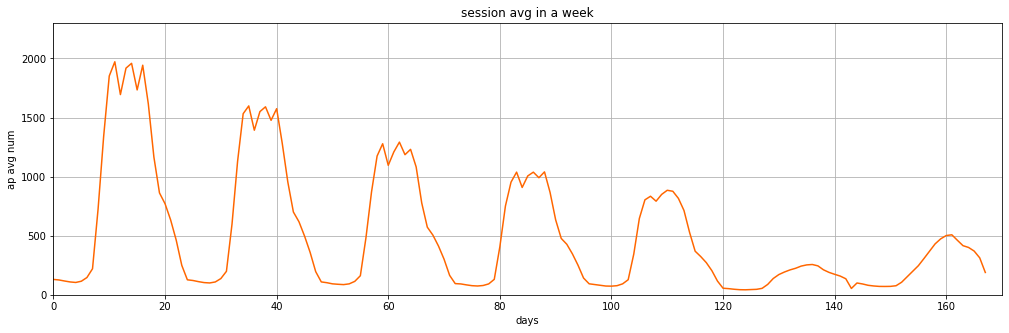

In [387]:
plt.rcParams["figure.figsize"] = (17,5)

plt.figure()
plt.subplot(1,1,1)
plt.ylim(0,2300)
plt.xlim(0,170)
plt.plot(totalday, color='#ff6600')
plt.title('session avg in a week')
plt.xlabel('days')
plt.ylabel('ap avg num')
plt.grid()

# (5,6) (7,8) (9,10) (11,12) 두달마다 평균애서 4개로 나눠서 표현

In [95]:
import datetime

def day_avg_by_two_month(month1, month2, dayday):
    
    avg_Mon = {}
    # month1과 month2사이의 데이터들
    special_month = {}
    for i in dayday.keys():
        day = 31
        if month2 ==6 or month2 ==9 or month2 ==11 :
            day = 30
        if i > datetime.date(2019, month1, 1) and i < datetime.date(2019, month2, day):
            special_month[i] = dayday[i]
        
    
    day_dt = special_month
    
    for hour in range(0,24):
        m_avg = 0
        m_sum = 0
        cnt = 0
        for m in day_dt:
            cnt+=1
            if hour in day_dt[m]:
                m_sum +=day_dt[m][hour]
            else:
                m_sum +=0
        m_avg = m_sum/cnt

        avg_Mon[hour] = m_avg
        
    return avg_Mon
    

In [120]:
monday_by_two_month = {}
tuesday_by_two_month = {}
wednesday_by_two_month = {}
thurseday_by_two_month = {}
friday_by_two_month = {}
saturday_by_two_month = {}
sunday_by_two_month = {}

index = 0
for i in range(5,12, 2):
    monday_by_two_month[index] = day_avg_by_two_month(i,i+1,Mon)
    tuesday_by_two_month[index] = day_avg_by_two_month(i,i+1,Tue)
    wednesday_by_two_month[index] = day_avg_by_two_month(i,i+1,Wed)
    thurseday_by_two_month[index] = day_avg_by_two_month(i,i+1,Thu)
    friday_by_two_month[index] = day_avg_by_two_month(i,i+1,Fri)
    saturday_by_two_month[index] = day_avg_by_two_month(i,i+1,Sat)
    sunday_by_two_month[index] = day_avg_by_two_month(i,i+1,Sun)
    index+=1



In [150]:
def totay_day_of_two_month(month1, month2):
    i=0
    if month1 == 5 and month2==6:
        i = 0
    elif month1 == 7 and month2==8:
        i = 1
    elif month1 == 9 and month2==10:
        i = 2
    else:
        i = 3
    
    mon_df = pd.DataFrame(pd.Series(monday_by_two_month[i]), columns=['avg'])
    tue_df = pd.DataFrame(pd.Series(tuesday_by_two_month[i]), columns=['avg'])
    wed_df = pd.DataFrame(pd.Series(wednesday_by_two_month[i]), columns=['avg'])
    thu_df = pd.DataFrame(pd.Series(thurseday_by_two_month[i]), columns=['avg'])
    fri_df = pd.DataFrame(pd.Series(friday_by_two_month[i]), columns=['avg'])
    sat_df = pd.DataFrame(pd.Series(saturday_by_two_month[i]), columns=['avg'])
    sun_df = pd.DataFrame(pd.Series(sunday_by_two_month[i]), columns=['avg'])
    
    ret_df = pd.concat([mon_df,tue_df, wed_df, thu_df, fri_df, sat_df, sun_df])
    
    return ret_df

In [151]:
May_to_June = totay_day_of_two_month(5,6)
July_to_August = totay_day_of_two_month(7,8)
Sep_to_Oct = totay_day_of_two_month(9,10)
Nov_to_Dec = totay_day_of_two_month(11,12)

In [154]:
total_month = pd.concat([May_to_June,July_to_August, Sep_to_Oct, Nov_to_Dec])

In [156]:
total_month = total_month.reset_index()

In [157]:
total_month = total_month.drop(['index'], axis='columns')

In [159]:
total_month.head(3)


,avg
0,259.076923
1,271.461538
2,253.000000


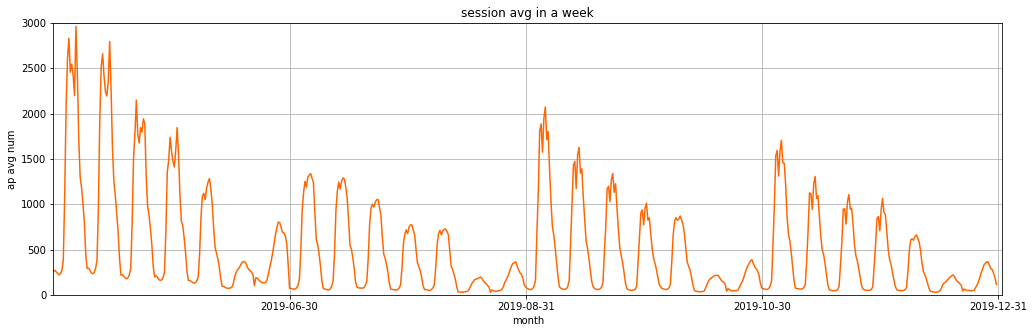

In [190]:
plt.rcParams["figure.figsize"] = (17,5)

plt.figure()
plt.subplot(1,1,1)
plt.ylim(0,3000)
plt.xlim(0,675)
plt.plot(total_month, color='#ff6600')
plt.title('session avg in a week')
plt.xlabel('month')
plt.xticks([168, 336,504, 672],['2019-06-30','2019-08-31','2019-10-30','2019-12-31'])
plt.ylabel('ap avg num')
plt.grid()

In [178]:
total_month

,avg
0,259.076923
1,271.461538
2,253.000000
3,236.461538
4,219.615385
...,...
667,286.090909
668,279.454545
669,237.545455
670,185.181818


In [188]:
24*7*4

672

#  한달마다 평균애서 4개로 나눠서 표현

In [310]:
import datetime

def day_avg_by_a_month(month, dayday):
    
    avg_Mon = {}
    # month의 데이터들
    special_month = {}
    
    for i in dayday.keys():
        day = 31
        if month ==6 or month ==9 or month ==11 :
            day = 30
        if i >= datetime.date(2019, month, 1) and i <= datetime.date(2019, month, day):
            special_month[i] = dayday[i]
        
    
    day_dt = special_month
    
    for hour in range(0,24):
        m_avg = 0
        m_sum = 0
        cnt = 0
        for m in day_dt:
            cnt+=1
            if hour in day_dt[m]:
                m_sum +=day_dt[m][hour]
            else:
                m_sum +=0
        m_avg = m_sum/cnt

        avg_Mon[hour] = m_avg
        
    return avg_Mon
    

In [311]:
monday_by_a_month = {}
tuesday_by_a_month = {}
wednesday_by_a_month = {}
thursday_by_a_month = {}
friday_by_a_month = {}
saturday_by_a_month = {}
sunday_by_a_month = {}

index = 0
for i in range(5,12):
    monday_by_a_month[index] = day_avg_by_a_month(i,Mon)
    tuesday_by_a_month[index] = day_avg_by_a_month(i,Tue)
    wednesday_by_a_month[index] = day_avg_by_a_month(i,Wed)
    thursday_by_a_month[index] = day_avg_by_a_month(i,Thu)
    friday_by_a_month[index] = day_avg_by_a_month(i,Fri)
    saturday_by_a_month[index] = day_avg_by_a_month(i,Sat)
    sunday_by_a_month[index] = day_avg_by_a_month(i,Sun)
    index+=1



In [345]:
def totay_day_of_a_month(month):
    if month==5:
        i = 0
    elif month==6:
        i = 1
    elif month==7:
        i = 2
    elif month==8:
        i = 3
    elif month==9:
        i = 4
    elif month==10:
        i = 5
    else:
        i = 6
    
    mon_df = pd.DataFrame(pd.Series(monday_by_a_month[i]), columns=['avg'])
    tue_df = pd.DataFrame(pd.Series(tuesday_by_a_month[i]), columns=['avg'])
    wed_df = pd.DataFrame(pd.Series(wednesday_by_a_month[i]), columns=['avg'])
    thu_df = pd.DataFrame(pd.Series(thursday_by_a_month[i]), columns=['avg'])
    fri_df = pd.DataFrame(pd.Series(friday_by_a_month[i]), columns=['avg'])
    sat_df = pd.DataFrame(pd.Series(saturday_by_a_month[i]), columns=['avg'])
    sun_df = pd.DataFrame(pd.Series(sunday_by_a_month[i]), columns=['avg'])
    
    ret_df = pd.concat([mon_df,tue_df, wed_df, thu_df, fri_df, sat_df, sun_df])
    
    return ret_df

In [377]:
May = totay_day_of_a_month(5)
June = totay_day_of_a_month(6)
July = totay_day_of_a_month(7)
August = totay_day_of_a_month(8)
September = totay_day_of_a_month(9)
October = totay_day_of_a_month(10)
November = totay_day_of_a_month(11)
Decemeber = totay_day_of_a_month(12)

In [378]:
all_month = pd.concat([May, June, July, August, September, October, November, Decemeber])

In [379]:
all_month = all_month.reset_index()

In [380]:
all_month = all_month.drop(['index'], axis='columns')

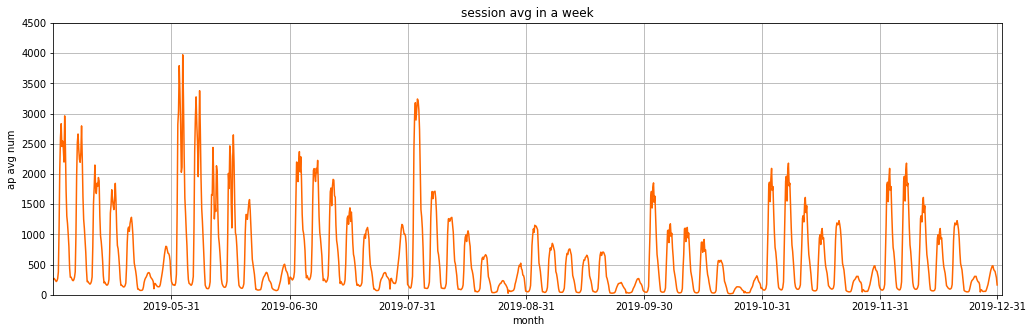

In [386]:
plt.rcParams["figure.figsize"] = (17,5)

plt.figure()
plt.subplot(1,1,1)
plt.ylim(0,4500)
plt.xlim(0,1350)
plt.plot(all_month, color='#ff6600')
plt.title('session avg in a week')
plt.xlabel('month')
plt.xticks([168, 336, 504, 672, 840,1008,1176,1343],['2019-05-31','2019-06-30','2019-07-31','2019-08-31','2019-09-30','2019-10-31','2019-11-31','2019-12-31'])
plt.ylabel('ap avg num')
plt.grid()

In [382]:
all_month

,avg
0,259.076923
1,271.461538
2,253.000000
3,236.461538
4,219.615385
...,...
1339,399.833333
1340,390.000000
1341,339.833333
1342,282.333333
